In [1]:
""" Importing libraries """
from ovito.io import *
from ovito.modifiers import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc_opt
import scipy.special as sc_spc

In [2]:
""" Rational polyomial used to fit the contact line distance

    The derivatives can be used to apply constraints on the 
    sign of the velocity and acceleration of the c.l. """

def rational(x, p, q) :
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rational_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [p0, p1, p2, p3], [q1,])
def ratioder_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [2*p0*q1, 3*p0+p1*q1, 2*p1, p2-p3*q1], [q1*q1, 2*q1,])
def ratiodr2_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [2*p0*q1*q1, 6*p0*q1, 6*p0, 2*(p1-p2*q1+p3*q1*q1)], [q1**3, 3*q1*q1, 3*q1])

In [3]:
""" Code to perform least-square fitting with constraints 

    Here it would be better to use renormalized data. """

def fit_cl_friction_ls(t, r, nf_ext=1, lvel=10, lacc=1, p0_cf=None, p0_ls=[1,1,1,1,1], mv=1000) :
    
        def rd_m(p) :
            r = ratioder_4_2(t[nf_ext:],*p)
            r[r>0] = 0
            return r 
        
        def r2_p(p) :
            r = ratiodr2_4_2(t[nf_ext:],*p)
            r[r<0] = 0
            return r 

        def fres(p):
            return np.concatenate((r[nf_ext:]-rational_4_2(t[nf_ext:],*p),lvel*rd_m(p),lacc*r2_p(p)),axis=None)

        ls_results = sc_opt.least_squares(fres, x0=p0_ls, max_nfev=mv)
        popt1 = ls_results.x
        r_fit = rational_4_2(t, *popt1)
        v_fit = ratioder_4_2(t, *popt1)

        return r_fit, v_fit

In [4]:
""" Generic function to determine the solid/liquid interface """
def get_sl_interface(cl, cs) :
    clz_min = np.min(cl[:,2])
    csz_max = np.max(cs[:,2])
    return 0.5*(clz_min+csz_max)

In [5]:
""" Generic function to determine the liquid/vapour interface locations """
def get_lv_interface(bins, target_dens) :
    r_int = 0
    for i in range(len(bins)) :
        if bins[i]>target_dens and bins[i+1]<=target_dens :
            r_int = ((i+1)*hr*(bins[i]-target_dens)+i*hr*(target_dens-bins[i+1]))/(bins[i]-bins[i+1])
            break
    return r_int

In [6]:
""" Define binning variables """
# Vertical bins
Nz = 2
hz = 4 # [Å]
# Radial bins
r0 = 10 # [Å]
Nr = 20
hr = 4 # [Å]
# Angular bins
# (not used at the moment, could be used to 
# compute the std from the CA of each slice)
Nt = 30
ht = 2*np.pi/Nt # [rad]

In [7]:
""" Simulation timestep """
dt = 0.001 # [ps]

In [8]:
""" Define arrays """
r_bins = np.linspace(r0+0.5*hr,r0+hr*(Nr-1)+0.5*hr,Nr)

In [9]:
""" Volume of each grid bin

    This can be computed beforehand since the bin size 
    is not changing, only the grid center is. """

bin_vol = np.pi*hz*(np.linspace(r0+hr,r0+hr*Nr,Nr)**2-np.linspace(r0,r0+hr*(Nr-1),Nr)**2)

In [10]:
""" Loading input file into an Ovito pipeline """
pipeline_wetting = import_file("wetting.dump")

In [11]:
""" Append modifiers to the pipeline (e.g. CNA, RDF, ...) """
pipeline_wetting.modifiers.append(CommonNeighborAnalysisModifier())
pipeline_wetting.modifiers.append(CoordinationAnalysisModifier(cutoff=10.0,partial=True))

In [12]:
""" Loop over simulation frames and do something """
n_frame = 0
contact_angle = []
cl_position = []
time = []
for data in pipeline_wetting.frames :
    
    time.append(dt*data.attributes['Timestep'])
    
    n_frame += 1
    print('frame # ',n_frame,'/',pipeline_wetting.num_frames)
    
    # Initializing the grid of bins
    bin_grid = np.zeros((Nr,Nz))
    ref_dens = np.zeros(Nz)
    r_int = np.zeros(Nz)
    
    coord_liq = data.particles.positions[data.particles['v_dummymol'] == 1]
    coord_liq = coord_liq[...]
    
    coord_sub = data.particles.positions[data.particles['v_dummymol'] == 2]
    coord_sub = coord_sub[...]
    
    # Determine the SL interface
    z_sl_int = get_sl_interface(coord_liq,coord_sub)
    z_upper = z_sl_int+Nz*hz
    
    # Coordinates of particles in the range of the vertical grid
    coord_near_wall = coord_liq[coord_liq[:,2]>z_sl_int]
    coord_near_wall = coord_near_wall[coord_near_wall[:,2]<z_upper]
    
    xmean_liq = np.mean(coord_near_wall[:,0])
    ymean_liq = np.mean(coord_near_wall[:,1])
    
    # Coordinates relative to the central axis
    x_liq_rel = coord_near_wall[:,0]-xmean_liq
    y_liq_rel = coord_near_wall[:,1]-ymean_liq
    r_liq = np.sqrt((x_liq_rel**2)+(y_liq_rel**2))
    z_liq = coord_near_wall[:,2]
    
    # Exclude particles near the pole
    r_liq_nopole = r_liq[r_liq>r0]
    z_liq_nopole = z_liq[r_liq>r0]
    
    # Compute reference number density
    z_liq_pole = z_liq[r_liq<=r0]
    jz = ((z_liq_pole-z_sl_int)//hz).astype(int)
    for n in range(len(z_liq_pole)) :
        ref_dens[jz[n]] += 1
    ref_dens /= (np.pi*hz*r0**2)
        
    # Binning
    ir = ((r_liq_nopole-r0)//hr).astype(int)
    jz = ((z_liq_nopole-z_sl_int)//hz).astype(int)
    for n in range(len(r_liq_nopole)) :
        bin_grid[ir[n],jz[n]] += 1
    bin_grid /= bin_vol[:,None]
    
    # Find the radial coordinate of the interface
    for j in range(Nz) :
        r_int[j] = get_lv_interface(bin_grid[:,j],0.5*ref_dens[j])
        r_int[j] += (r0+0.5*hr)
    
    # Extract the radial contact line coordinate from the last bin
    cl_position.append(r_int[0])
    
    # Extract the contact angle from interface position
    # SIMPLIFIED CASE: ONLY TWO POINTS
    dr = r_int[0]-r_int[1]
    dz = hz
    ca = 0.5*(dr==0)*np.pi+(dr>0)*np.arctan(dz/dr)+(dr<0)*(0.5*np.pi-np.arctan(dz/dr))
    contact_angle.append(np.rad2deg(ca))

frame #  1 / 201
frame #  2 / 201
frame #  3 / 201
frame #  4 / 201
frame #  5 / 201
frame #  6 / 201
frame #  7 / 201
frame #  8 / 201
frame #  9 / 201
frame #  10 / 201
frame #  11 / 201
frame #  12 / 201
frame #  13 / 201
frame #  14 / 201
frame #  15 / 201
frame #  16 / 201
frame #  17 / 201
frame #  18 / 201
frame #  19 / 201
frame #  20 / 201
frame #  21 / 201
frame #  22 / 201
frame #  23 / 201
frame #  24 / 201
frame #  25 / 201
frame #  26 / 201
frame #  27 / 201
frame #  28 / 201
frame #  29 / 201
frame #  30 / 201
frame #  31 / 201
frame #  32 / 201
frame #  33 / 201
frame #  34 / 201
frame #  35 / 201
frame #  36 / 201
frame #  37 / 201
frame #  38 / 201
frame #  39 / 201
frame #  40 / 201
frame #  41 / 201
frame #  42 / 201
frame #  43 / 201
frame #  44 / 201
frame #  45 / 201
frame #  46 / 201
frame #  47 / 201
frame #  48 / 201
frame #  49 / 201
frame #  50 / 201
frame #  51 / 201
frame #  52 / 201
frame #  53 / 201
frame #  54 / 201
frame #  55 / 201
frame #  56 / 201
f

In [24]:
""" Fitting contact line displacement """

#Number of frames to exclude
nf_ext = 5

# popt1, pcov1 = sc_opt.curve_fit(rational_4_2, time[nf_ext:], cl_position[nf_ext:], maxfev=1000)
# r_fit = rational_4_2(time, *popt1)
# v_fit = ratioder_4_2(time, *popt1)

# OR

r_fit, v_fit = fit_cl_friction_ls(time, cl_position, nf_ext, lvel=2500, lacc=1000, 
                                  p0_cf=None, p0_ls=[1,1,1,1,1], mv=1000)

In [ ]:
""" Some filtering in necessary on the contact angle,
    it's too noisy otherwise. """

## Plotting results

<IPython.core.display.Javascript object>


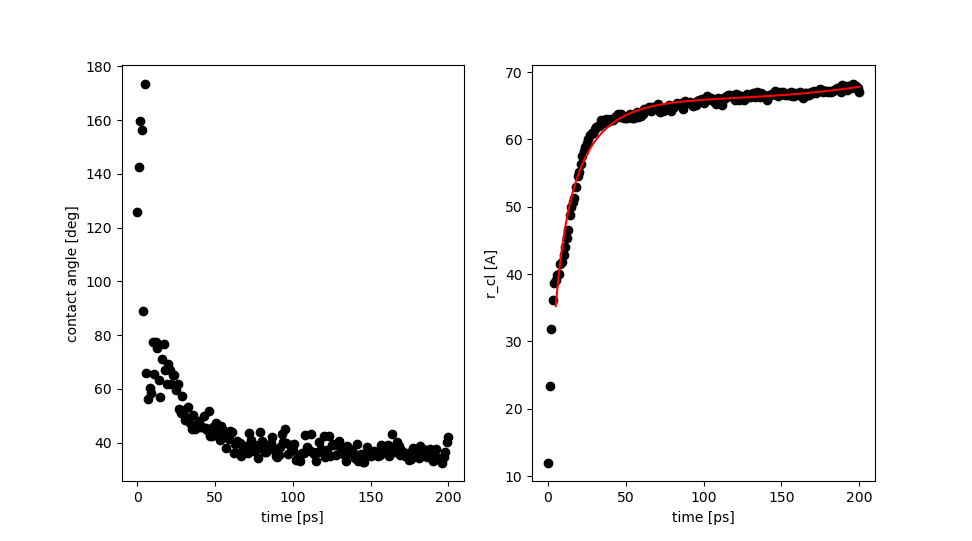

In [25]:
%matplotlib notebook

# fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(time,contact_angle,'ko')
ax1.set_xlabel("time [ps]")
ax1.set_ylabel("contact angle [deg]")

ax2.plot(time,cl_position,'ko')
ax2.plot(time[nf_ext:],r_fit[nf_ext:],'r-')
ax2.set_xlabel("time [ps]")
ax2.set_ylabel("r_cl [A]")

# ax3.plot(time[nf_ext:],v_fit[nf_ext:],'r-')
# ax3.set_xlabel("time [ps]")
# ax3.set_ylabel("v_cl [A/ps]")

plt.show()

<IPython.core.display.Javascript object>


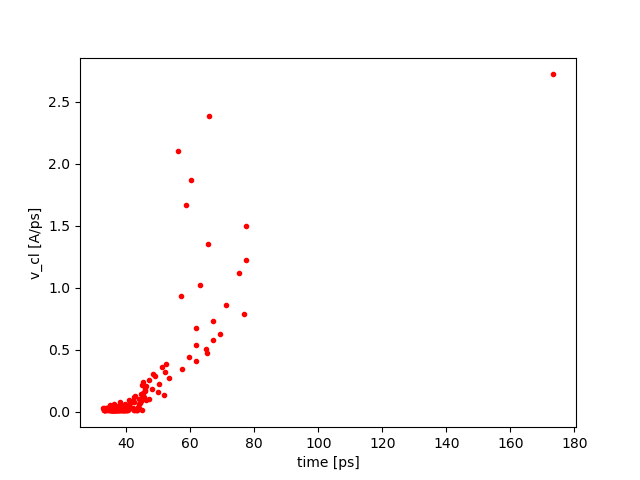

In [26]:
%matplotlib notebook
plt.plot(contact_angle[nf_ext:],v_fit[nf_ext:],'r.')
plt.xlabel("time [ps]")
plt.ylabel("v_cl [A/ps]")
plt.show()

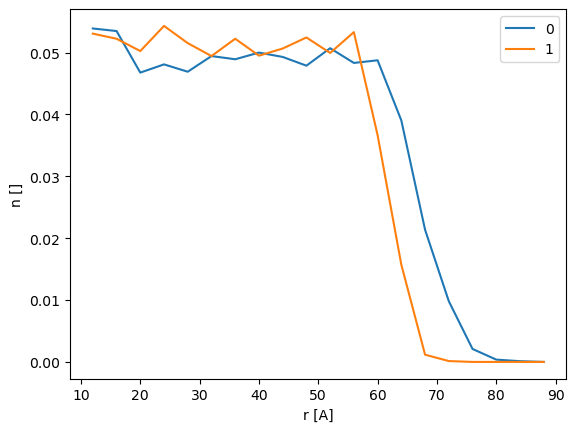

In [27]:
%matplotlib inline
for j in range(Nz) :
    plt.plot(r_bins,bin_grid[:,j],label=str(j))
plt.legend()
plt.xlabel('r [A]')
plt.ylabel('n []')
plt.show()

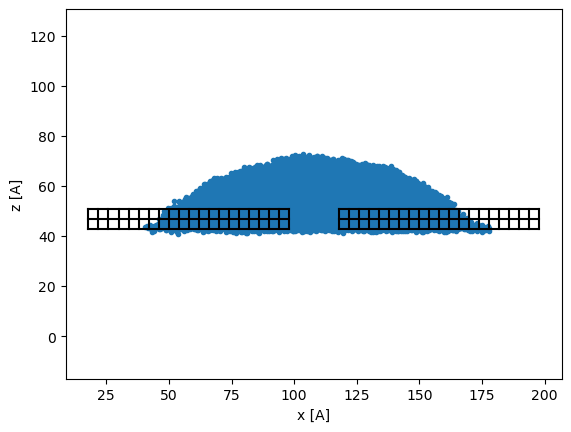

In [28]:
""" Example: 2D scatterplot (xz) of the last fame and SL interface """
%matplotlib inline
fig, ax1 = plt.subplots(1)
ax1.scatter(coord_liq[:,0],coord_liq[:,2],marker='.')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int,z_sl_int],'k-')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int+hz,z_sl_int+hz],'k-')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int+2*hz,z_sl_int+2*hz],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int,z_sl_int],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int+hz,z_sl_int+hz],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int+2*hz,z_sl_int+2*hz],'k-')
for i in range(Nr+1) :
    ax1.plot([xmean_liq+i*hr+r0,xmean_liq+i*hr+r0],[z_sl_int,z_sl_int+2*hz],'k-')
    ax1.plot([xmean_liq-i*hr-r0,xmean_liq-i*hr-r0],[z_sl_int,z_sl_int+2*hz],'k-')
ax1.axis('equal')
ax1.set_xlabel('x [A]')
ax1.set_ylabel('z [A]')
plt.show()

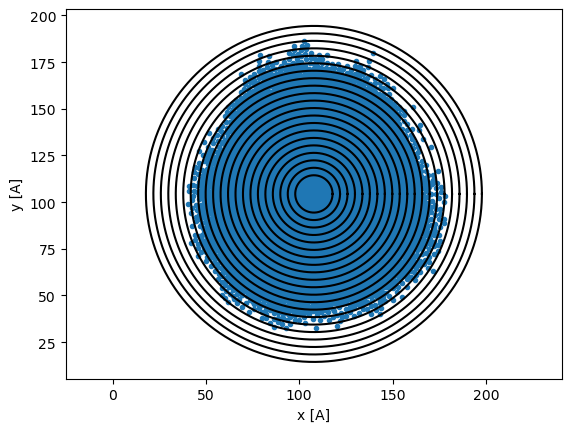

In [29]:
""" Example: 2D scatterplot (xy) of the last fame and radial bins """
%matplotlib inline
fig, ax1 = plt.subplots(1)
ax1.scatter(coord_liq[:,0],coord_liq[:,1],marker='.')
# for i in range(Nt) :
#     rx = xmean_liq+Nr*hr*np.cos(i*ht)*np.linspace(0,1,10)+r0*np.cos(i*ht)
#     ry = ymean_liq+Nr*hr*np.sin(i*ht)*np.linspace(0,1,10)+r0*np.sin(i*ht)
#     ax1.plot(rx,ry,'k-')
for i in range(Nr+1) :
    ax1.plot(xmean_liq+(r0+i*hr)*np.cos(np.linspace(0,2*np.pi,500)),
        ymean_liq+(r0+i*hr)*np.sin(np.linspace(0,2*np.pi,500)),'k-')
ax1.axis('equal')
ax1.set_xlabel('x [A]')
ax1.set_ylabel('y [A]')
plt.show()

In [15]:
""" Example: plot the Al-Al RDF of the last frame """
# rdf_table = pipeline_wetting.compute().tables['coordination-rdf']
# print('Combination of atom types: ',rdf_table.y.component_names)
# rdf_y = rdf_table.y[:,0]
# rdf_x = rdf_table.xy()[...][:,0]
# %matplotlib inline
# plt.plot(rdf_x,rdf_y)

' Example: plot the Al-Al RDF of the last frame '

In [16]:
""" Example: 3D scatterplot of the last fame """
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(coord_sub[:,0],coord_sub[:,1],coord_sub[:,2],marker='.')
# ax.scatter(coord_liq[:,0],coord_liq[:,1],coord_liq[:,2],marker='.')
# plt.axis('equal')
# plt.show()

' Example: 3D scatterplot of the last fame '